In [1]:
import pandas as pd
import os
from geopy.distance import vincenty
import json
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def get_dist_km(stn_id_1, stn_id_2, df):
    
    i_1 = df.query('station_id == @stn_id_1').index[0]
    i_2 = df.query('station_id == @stn_id_2').index[0]

    coords_1 = (df.latitude_decimal_degrees[i_1], df.longitude_decimal_degrees[i_1])
    coords_2 = (df.latitude_decimal_degrees[i_2], df.longitude_decimal_degrees[i_2])
    
    dist = vincenty(coords_1, coords_2)
    
    return dist.kilometers

In [6]:
df1 = pd.DataFrame.from_csv('../data/station_longlist.csv')
df2 = pd.DataFrame.from_csv('../data/station_shortlist.csv')

(60, 70)

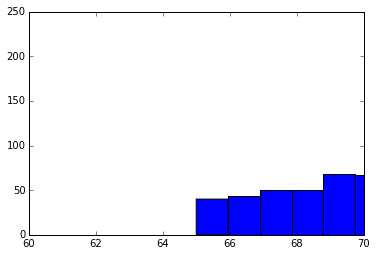

In [7]:
plt.hist([x for x in df2.T_high_nan if x == x], bins=700);
plt.xlim([60, 70])

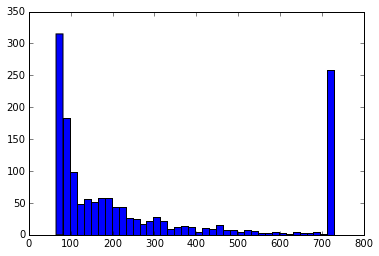

In [8]:
plt.hist([x for x in df2.h_all_precip_nan if x == x], bins=40);

In [9]:
bad_rows_1 = df2.query('h_all_precip_nan != h_all_precip_nan and T_high_nan != T_high_nan').index
bad_rows_2 = df2.query('h_all_precip_nan > 700 and T_high_nan > 700').index
df2 = df2.drop(bad_rows_1 + bad_rows_2)

In [10]:
df2.to_csv('../data/station_shorterlist.csv')

In [11]:
len(df2)

1338

In [12]:
df2.columns

Index([u'Unnamed: 0.1', u'name', u'province', u'climate_id', u'station_id', u'wmo_id', u'tc_id', u'latitude_decimal_degrees', u'longitude_decimal_degrees', u'latitude', u'longitude', u'elevation_m', u'start_date', u'end_date', u'h_rain_nan', u'T_low_nan', u'date_nan', u'h_snow_nan', u'T_high_nan', u'h_all_precip_nan', u'T_high_avg_nan', u'T_min_nan', u'T_low_avg_nan', u'T_max_nan', u'period_T_low_nan', u'period_T_high_nan', u'T_min_year_nan', u'day_nan', u'T_max_year_nan', u'month_nan', u'alm_stn_id', u'alm_stn_dist', u'norm_stn_id', u'norm_stn_dist'], dtype='object')

In [13]:
# make a dict where key is stn_id and val is a list of the 10 closest stations in that province
closest = {}
for i1 in df2.index[:]:
    print i1,
    stn_id_1 = df2.station_id[i1]
    prov = df2.province[i1]
    index_2 = df2.query('province == @prov').index
    dist_list = []
    for i2 in index_2:
        stn_id_2 = df2.station_id[i2]
        dist = get_dist_km(stn_id_1, stn_id_2, df2)
        dist_list.append((stn_id_2, dist))
    dist_list.sort(key=lambda d: d[1])
    closest[stn_id_1] = dist_list[1:11]

0 1 2 3 4 5 6 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 26 27 28 29 30 31 33 34 35 36 37 38 39 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 80 81 82 83 84 85 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 122 123 124 125 126 127 128 129 130 131 133 134 135 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 153 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 173 174 175 176 177 178 179 180 181 182 183 184 186 187 188 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 219 220 221 222 223 224 225 226 227 228 229 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 280 281 282 283 284 285 286 287 289 290 291 292 293 29

In [20]:
f = open('../data/closest_daily_weather_dict.json', 'w')
json.dump(closest, f)
f.close()

In [133]:
min(df2.T_high_nan)

65.0

In [169]:
col_categories = [{'name': 'temp', 'src_id_col': 'temp_src_id', 'cols': ['T_high', 'T_low']},
                  {'name': 'precip', 'src_id_col': 'precip_src_id', 
                   'cols': ['h_rain', 'h_snow', 'h_all_precip']}]

def add_src_cols(df):
    for d in src_cols:
        df[d['src_id_col']] = pd.Series(index=df.index)
    return df

def fill_in(df_main, df_filler, filler_stn_id):
    "Fill in the missing values in df_main with some from df_filler"
    nan_prefill = {}
    for d in col_categories:
        main_nan = set([])
        filler_notnan = set([])
        for c in d['cols']:
            main_nan = main_nan.union(set(list(df_main.query(c + ' != ' + c).index)))
            filler_notnan = filler_notnan.union(set(list(df_filler.query(c + ' == ' + c).index)))
        nan_prefill[d['name']] = len(main_nan)
        if len(main_nan) < 66: # 65 nan values is the minimum based on when the files were downloaded
            continue
        indices_to_fill = main_nan.intersection(filler_notnan)
        for i in indices_to_fill:
            for c in d['cols']:
                df_main.ix[i, c] = df_filler[c][i]
            df_main.ix[i, d['src_id_col']] = filler_stn_id
    return df_main, nan_prefill

def save_filled_df(df, stn_id):
    df.to_csv('../data/daily_weather_filled/' + str(stn_id) + '.csv')

In [167]:
df2['temp_nan_post_fill'] = pd.Series(index=df2.index)
df2['precip_nan_post_fill'] = pd.Series(index=df2.index)

In [168]:
nan_prefill

{'precip': 66, 'temp': 65}

In [174]:
for i in df2.index[1190:]:
    try: 
        s1 = df2.station_id[i]
        df_s1 = pd.DataFrame.from_csv('../data/daily_weather/' + str(s1) + '.csv')
        df_s1 = add_src_cols(df_s1)
        for n, d in enumerate(closest[s1]):
            s2 = d[0]
            dist = d[1]
            df_s2 = pd.DataFrame.from_csv('../data/daily_weather/' + str(s2) + '.csv')
            df_s1, nan_prefill = fill_in(df_s1, df_s2, s2)
            if nan_prefill['temp'] < 66 and nan_prefill['precip'] < 66:
                break
        df2.ix[i, 'temp_nan_post_fill'] = nan_prefill['temp']
        df2.ix[i, 'precip_nan_post_fill'] = nan_prefill['precip']
        save_filled_df(df_s1, s1)
        print i, nan_prefill, n, dist
    except:
        print i, 'fail'

1322 fail
1324 fail
1325 fail
1326 {'precip': 151, 'temp': 65} 9 203.158967306
1327 {'precip': 151, 'temp': 65} 9 202.439408473
1329 {'precip': 151, 'temp': 65} 9 189.054992412
1330 {'precip': 154, 'temp': 65} 9 189.054992412
1331 {'precip': 151, 'temp': 65} 9 190.171135988
1333 {'precip': 151, 'temp': 65} 9 240.369474912
1336 fail
1342 fail
1347 fail
1350 fail
1351 {'precip': 361, 'temp': 65} 9 512.169524065
1352 {'precip': 361, 'temp': 65} 9 511.009834221
1356 {'precip': 66, 'temp': 65} 9 131.577881727
1357 {'precip': 65, 'temp': 65} 4 100.238143239
1358 {'precip': 65, 'temp': 65} 4 98.818676363
1359 {'precip': 65, 'temp': 65} 4 70.8495569088
1360 {'precip': 66, 'temp': 65} 9 145.441403008
1361 {'precip': 65, 'temp': 65} 4 114.135149019
1362 {'precip': 65, 'temp': 65} 7 100.238143239
1363 {'precip': 157, 'temp': 65} 9 98.8305949216
1364 {'precip': 65, 'temp': 65} 7 196.217737365
1365 {'precip': 65, 'temp': 65} 7 85.0208521315
1367 {'precip': 65, 'temp': 65} 9 87.6739851006
1368 {'pre

In [175]:
df2.to_csv('../data/station_shorterlist.csv')

In [87]:
df_s1 = pd.DataFrame.from_csv('../data/daily_weather/' + str(s1) + '.csv')
df_s2 = pd.DataFrame.from_csv('../data/daily_weather/' + str(s2) + '.csv')

In [102]:
df_s1.columns

Index([u'T_high', u'T_low', u'h_rain', u'h_snow', u'h_all_precip', u'temp_src_id', u'precip_src_id'], dtype='object')

In [80]:
for c in df_s1.columns:
    if '_src_id' in c: continue
    print c, len(df_s1.query(c + ' != ' + c))

T_high 230
T_low 229
h_rain 230
h_snow 230
h_all_precip 230


In [75]:
a = set([1])
b = set([1, 4])

In [ ]:
a.intersection

In [96]:
len(main_nan_groups['temp_src_id'])

293

In [98]:
len(filler_notnan_groups['temp_src_id'])

394

In [81]:
df_3 = fill_in(df_s1, df_s2, s2)

In [177]:
df2.columns

Index([u'name', u'province', u'climate_id', u'station_id', u'wmo_id', u'tc_id', u'latitude_decimal_degrees', u'longitude_decimal_degrees', u'latitude', u'longitude', u'elevation_m', u'start_date', u'end_date', u'h_rain_nan', u'T_low_nan', u'date_nan', u'h_snow_nan', u'T_high_nan', u'h_all_precip_nan', u'T_high_avg_nan', u'T_min_nan', u'T_low_avg_nan', u'T_max_nan', u'period_T_low_nan', u'period_T_high_nan', u'T_min_year_nan', u'day_nan', u'T_max_year_nan', u'month_nan', u'alm_stn_id', u'alm_stn_dist', u'norm_stn_id', u'norm_stn_dist', u'temp_nan_post_fill', u'precip_nan_post_fill'], dtype='object')

In [15]:
stn_id_dict = {}
for i in df2.index:
    stn_id_dict[str(df2.station_id[i])] = {'stn_id_almanac': str(int(df2.alm_stn_id[i])),
                                   'stn_id_normals': str(int(df2.norm_stn_id[i]))}

In [16]:
f = open('../data/stn_id_dict.json', 'w')
json.dump(stn_id_dict, f)
f.close()

In [190]:
dfn = pd.DataFrame.from_csv('../data/normals/precip_only_short.csv', index_col=False)

In [200]:
normal_id_dict = {52: 'h_rain_mm', 54: 'h_snow_cm', 56: 'h_all_precip_mm'}

In [214]:
# stn_id = 1518
for stn_id in list(set(dfn.STATION_ID))[:]:
    df_temp = pd.DataFrame(columns=normal_id_dict.values(), index=range(1, 13))
    df_temp.index.name = 'month'
    for nid in normal_id_dict:
        indices = dfn.query('STATION_ID == ' + str(stn_id) + ' and NORMAL_ID == ' + str(nid)).index
        df_temp[normal_id_dict[nid]] = pd.Series(list(dfn.VALUE[indices]), index=list(dfn.MONTH[indices]))
    df_temp.to_csv('../data/normals/' + str(stn_id) + '.csv')

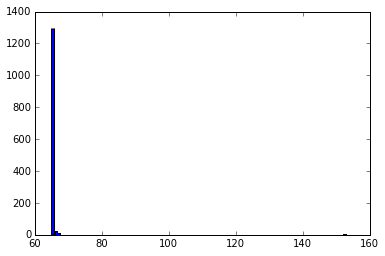

In [219]:
plt.hist([x for x in list(df2.temp_nan_post_fill) if x==x], bins=100);

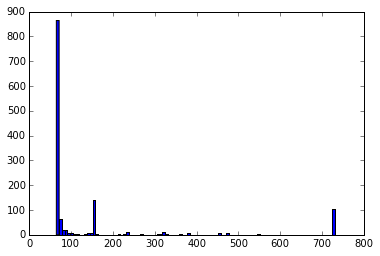

In [220]:
plt.hist([x for x in list(df2.precip_nan_post_fill) if x==x], bins=100);

In [222]:
indices2drop = df2.query('precip_nan_post_fill > 100 or temp_nan_post_fill > 100').index

In [223]:
len(indices2drop)

353

In [224]:
len(df2)

1338

In [225]:
df3 = df2.copy()

In [227]:
df3 = df3.drop(indices2drop)

In [228]:
len(df3)

985

In [229]:
df3.to_csv('../data/station_even_shorterlist.csv')